## Problem Statement

While traditional methods for alerting on events such as hurricanes and tornadoes rely on information derived from official sources (e.g. USGS), this project aims to utilize Twitter activity to identify such an event. In practice, once the event is predicted, an alert can then be sent out across social media. The outcome of this project will be a binary classification model that can analyze tweets and use them to predict whether a disaster is present and a warning must be sent. As a proof of concept, this project will use archived tweets collected during the most dangerous days of Hurricane Sandy in 2012. The project's terminology will center around that of hurricanes specifically. In this situation, predicting no emergency while a hurricane approaches (false negative) is a much more dangerous outcome than predicting a hurricane when there is none (false positive). Models will therefore be evaluated on recall as well as accuracy.

## Executive Summary

### Data Acquisition

I initially atttempted to use Twitter's API to collect live data. I also tried to use tweet IDs from archived datasets to obtain exact data on the location and datetime of each tweet. This only yielded a small amount of data, not enough to for prediciton. For the scope of this project, I needed a time-efficient solution. I decided to take CrisisLex's dataset of archived tweets during Hurricane Sandy and use them to predict the presence of a hurricane. CrisisLex is a repository of social media data on various crises and natural disasters. This dataset consists of tweets taken from late October 2012, posted by users in coastal New York and New Jersey, and based on 4 keywords: hurricane, hurricane sandy, frankenstorm, and #sandy. One columns lists tweets as "on-topic" or "off-topic", meaning their relevance or irrelevance to the subject of the hurricane. This column is the basis of my binary classification.

### Data Cleaning and EDA

In this dataset, duplicated rows in the "tweets" column would refer to retweets. These rows are dropped so that tweets are not counted more than once, which would give some predictive words too much weight, leading to potential bias in the model. The positive class is the presence of a hurricane, so I set "on-topic" to 1 and "off-topic" to 0. I vectorized the corpus of tweets, and observed the most common words across the entire corpus and between the two classes. Irrelevant words from the positive class were added to the list of stop words to ensure that it was distinct from the negative class. I then used a clustering model to view the overlap between the two classes.

### Modeling

I started with logistic regression models to see if a simpler model would suffice. Following that, I used random forest models to determine if more complexity would lead to more accurate predictions, but these models underperformed. I also experimented with two different methods of vectorizing the tweets. As I conducted EDA, I added words to the list of stop words and re-examined the four models with various versions of the list. This did not have a marked effect on the models' performance. I selected the logistic regression model with CountVectorizer for its accuracy and low variance compared to the random forest models. The recall score of this model is high, meaning that false negatives are kept to a minimum. The strongest feature coefficients of this model correspond with words that are highly relevant to a hurricane. This includes direct references to the event and also to safety precautions taken during a disaster.

## Loading Libraries and Data

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
set(stopwords.words('english'));
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [47]:
df = pd.read_csv('data/sandy.csv')
df.head()

,tweet id,tweet,label
0,262596552399396864,I've got enough candles to supply a Mexican fa...,0
1,263044104500420609,Sandy be soooo mad that she be shattering our ...,1
2,263309629973491712,@ibexgirl thankfully Hurricane Waugh played it...,0
3,263422851133079552,@taos you never got that magnificent case of B...,0
4,262404311223504896,"I'm at Mad River Bar &amp; Grille (New York, N...",0


## Preprocessing

In [48]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [49]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['rt', 'http', 'just', 'like', 'new', 'people', 'school', 'hope', 
                  'going', 'to', 'co', 'even', 'go', 'get', 'shit', 'lol', 'would'])

These stop words were added according to the exploratory data analysis. Adding to the list yields more relevant words to predict on. The models below were run with various versions of this list, yet after a certain point, adding more words to the list did not affect model accuracy. The list seen here is the final list of stop words used in the models.

## Modeling

## Baseline Model

In [50]:
y_test.value_counts(normalize=True)

1    0.597116
0    0.402884
Name: label, dtype: float64

The baseline score is 60% in favor of predicting a hurricane. Any acceptable model will need an accuracy score higher than this.

## Logistic Regression

### With CountVectorizer

In [51]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords)),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

pipe_params = {
    'cvec__max_features': [None, 500, 1000, 5000],
    'cvec__min_df': [2, 5],
    'cvec__max_df': [0.1,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

gs1 = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)

gs1.fit(X_train, y_train)
gs1_model = gs1.best_estimator_
print(gs1_model.score(X_train, y_train))
print(gs1_model.score(X_test, y_test))
print(cross_val_score(gs1_model, X, y, cv=5).mean())

0.9384985154814082
0.9194232400339271
0.8856109185792838


### With TfIdfVectorizer

In [43]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwords)),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

pipe_params = {
    'tvec__max_features': [None, 500, 1000, 5000],
    'tvec__min_df': [2, 5],
    'tvec__max_df': [0.1,.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': ['english']
}

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)

gs.fit(X_train, y_train)
gs_model = gs.best_estimator_
print(gs_model.score(X_train, y_train))
print(gs_model.score(X_test, y_test))
print(cross_val_score(gs_model, X, y, cv=5).mean())

0.9310052311607522
0.9147582697201018
0.879992468859513


These models have high accuracy and low variance. I want to see if using a random forest can lead to improvement.

## Random Forest Classifier

### With CountVectorizer

In [52]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords)),
    ('rf', RandomForestClassifier(bootstrap=True))
])

pipe_params = {
    'cvec__max_features': [None, 500, 1000, 5000],
    'cvec__min_df': [2, 5],
    'cvec__max_df': [0.1,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english']
}

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)

gs.fit(X_train, y_train)
gs_model = gs.best_estimator_
print(gs_model.score(X_train, y_train))
print(gs_model.score(X_test, y_test))
print(cross_val_score(gs_model, X, y, cv=5).mean())

0.9926480984023752
0.909245122985581
0.882638748573586


### With TfIdfVectorizer

In [53]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwords)),
    ('rf', RandomForestClassifier(bootstrap=True))
])

pipe_params = {
    'tvec__max_features': [None, 500, 1000, 5000],
    'tvec__min_df': [2, 5],
    'tvec__max_df': [0.1,.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': ['english']
}

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)

gs.fit(X_train, y_train)
gs_model = gs.best_estimator_
print(gs_model.score(X_train, y_train))
print(gs_model.score(X_test, y_test))
print(cross_val_score(gs_model, X, y, cv=5).mean())

0.9910928884490315
0.9151823579304496
0.8796724237558482


The random forest models also have high accuracy yet, unexpectedly, their variance is larger than those of the logistic regression models. 

## Model Selection

The logistic regression model with CountVectorizer is the most accutate. This model offers high accuracy with the lowest variance available. I will proceed to making predicitons with this model.

## Model Evaluation

### Accuracy and Recall

In [42]:
y_pred = gs1.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9194232400339271


In [63]:
tp = 1296
fn = 112
tp / (tp + fn)

0.9204545454545454

Accuracy = 92%

Recall = 92%

I am satisfied with these scores. The accuracy is high, and the high recall indicates that false negatives are kept to a minimum. The numbers used to calculate recall can be found in the confusio matrix below.

### Confusion Matrix

Text(0.5, 1, 'Confusion Matrix')

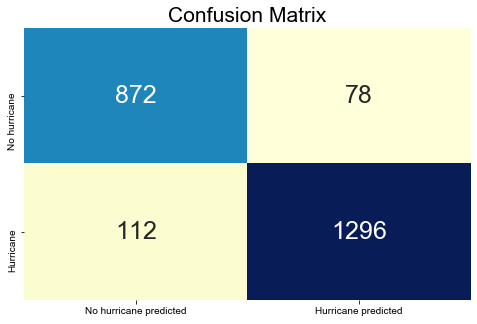

In [55]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['No hurricane predicted', 'Hurricane predicted'], 
                     index=['No hurricane', 'Hurricane'])

plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='d', annot_kws={"size": 25}, cbar=False, cmap="YlGnBu")
sns.set(font_scale=1.75)
plt.title('Confusion Matrix')

This matrix shows a much higher number of correct predictions than incorrect. The number of false negatives (112) is higher than the number of false positives, but this could be because the positive class was more numerous to begin with.

### ROC Curve

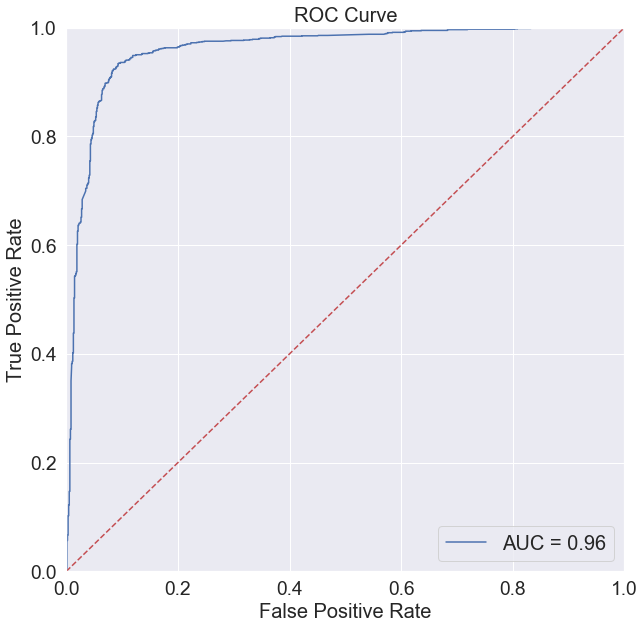

In [56]:
probs = gs1.predict_proba(X_test) # Via StackOverflow
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=20)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.show()

The area under the curve is very close to 1, so this model successfully separates the two classes.

### Examining Feature Coefficients

In [62]:
top_features = pd.DataFrame(list(zip(gs1.best_estimator_.steps[0][1].get_feature_names(), # Code from Freda Xin
                      gs1.best_estimator_.steps[1][1].coef_[0])), columns=['word', 'coefficient'])
top_features.sort_values(by='coefficient', ascending=False).head(30)

,word,coefficient
192,hurricane,5.113822
200,hurricanesandy,3.887277
135,frankenstorm,3.555969
353,sandy,3.515541
394,storm,3.431930
199,hurricanes,2.917694
324,power,2.503436
463,water,2.104734
83,damage,1.869608
51,building,1.821299


These words are the strongest predictors in the model. Some explicity mention hurricanes or storms, and many more mention words that become common during an emergency: 'damage', 'closed', 'relief', etc. These are the words we want to mark as dangerous. Words that pertain to a hurricane should lead to a prediction that a hurricane is approaching.

## Conclusion and Next Steps

This model accurately predicts whether or not a hurricane is present. A positive prediction could be used as the catalyst to send a storm warning across social media. 

Moving forward, it may be useful to consider if a retweet could add to a word's use in the model, rather than bias. I would like to look at Twitter handles and hashtags to see if any should be followed for more precise knowledge of approaching storms. This model can be applied to various types of natural disaster. The tweets would simply need to be searched using different keywords. It is possible to use the Twitter API to collect live data, which would fulfill the ultimate goal of a realtime alert system. This system could also be set up to be on higher alert during certain season. The National Hurricane Center reports that the height of hurricane season is mid-August to late October. If predicting hurrianes, for example, this warning system could be programmed to pull data and predict hurricanes throughout the season.